## Leaky binary models

#### Requirements
* Neuron values are either 0 or 1 (binary). The inputs and outputs for sure, and internally as much as possible.
* Weights are real values, which are maybe bounded. 

#### Modified Heaviside

The Heaviside function is defined as 
$$
H(x):=\begin{cases}1 \quad x\geq 0\\0 \quad x< 0.\end{cases}
$$
Mathematically, it has vanishing differential, because $H$ is essentially constant. 

<!-- We will use the following leaky variant of $H$, which depends on a non-negative constant $Q$:
$$
H(x, Q):= \begin{cases} 1 \quad x\geq 0\\ Q \quad x< 0.\end{cases}
$$ -->
For our purpose, it will be convenient to use the following differential for $H$, 
$$
H_{\text{backward}} := \begin{cases} 1 \quad x\geq 0\\ -1 \quad x< 0.\end{cases}
$$


#### Internal binary representation

In order to use classical float based layers for binary computations, we will use a leaky variant of a binary tensor. Instead of $[1, 0, 0, 1]$ we will use $[1, Q, Q, 1]$, where $Q<1$ is a non-negative constant, which is typically small. This will help to overcome a stop of the learning process, when too many neurons are inert, that is, do not propagate any signals.

The inputs and outputs will be binary. The function `binary_in` will turn all zeros into $Q$. The differential of `binary_in` is non-trivial, it is $=1$ on a $1$, and $=-1$ on a $0$, and then followed by a $\text{ReLU}$. As an example:
$$
\text{binary{\_}in}_{\text{backward at} [1, 0, 0, 1]}([y_0, y_1, y_2, y_3]) = \text{ReLU}([y_0, -y_1, -y_2, y_3]). 
$$
Is the $\text{ReLU}$ a choice or required?

#### Wrapping a float layer or model

Let $L$ be a classical layer, model, or autograd function. We can wrap transform it to $L\rightarrow L_{b}$ by composing with $H$ and $\text{binary{\_}in}$:
$$
L_{b} := H \circ L \circ \text{binary{\_}in}. 
$$
This is not very intuitive, need an example here.

Open points:
* The initialization of parameters will likely be different.

#### Heuristic of the learning algorithm

Let us consider the simplest case $y=L(x, w)$, in other words $x \xrightarrow{L} y$, where $x, y$ are $1$-dimensional tensors. We will assume that $L$ has a backward pass given by differential analysis.

We would like to understand the forward and backward pass of $L_b$:
$$
x \xrightarrow{L_b} y, \quad gy \xrightarrow{L_{b, \text{backward at\,} x}} gx, gw.
$$
Now, $x$ and $y$ are binary and have values in $\{0, 1\}$. The gradients $gx, gy$ will be non-negative floats (thanks to the `ReLU` in `binary_in`), but let's ignore this. The gradient $gw$ will consist of floats. 

The significance of $gy$ is given by the following. Whenever $gy$ is positive, the behavior of $y$ should change: if it was $0$ then it should become $1$ and vice versa. The more positive $gy$ is, the more urgent it is for $y$ to change. If $gy$ is negative, then the behavior should stay the same.

We compute
$$
gw = \text{sign}(y-0.5) \cdot gy\cdot  L_{\text{$w$-backward at\,} \text{binary{\_}in}(x)}(1),
$$
where $\text{sign}(y-0.5)$ is $=1$ if $y=1$ and $-1$ otherwise, it comes from the backward pass of the Heaviside. 

A modification $w - \epsilon \cdot gw$ would lead to 
$$
L(\text{binary{\_}in}(x), w- \epsilon \cdot gw) = L(\text{binary{\_}in}(x), w) - \epsilon \cdot \text{sign}(y-0.5) \cdot gy \cdot   (v, v),  
$$
where $v=L_{w-\text{backward at\,} \text{binary{\_}in}(x)}(1)$, and ignoring $\epsilon^2$. If $y=1$ this is trying to change the value of $L$ according to the sign of $-gy$. If $y=0$, it is trying to change the value of $L$ according to the sign of $gy$. That's the desired behavior.

Frequently, we will have an $L$, where $L_{w-\text{backward at\,} x}(1)=0$ if $x=0$. For example, that's the case if $L$ is linear. Therefore we use `binary_in` and get $L_{w-\text{backward at\,} \text{binary{\_}in}(x)}(1)\neq 0$ in most cases.

Let's consider $gx$. We compute
$$
gx = \text{sign}(y-0.5)\cdot \text{sign}(x-0.5) \cdot gy\cdot L_{x-\text{backward at\,} x}(1).
$$
A modification $x - \epsilon \cdot gx$ doesn't really make sense for two reasons:
* $x$ is binary
* From the previous part, we know that the value of $x$ will change according to $-\text{sign}(x-0.5) \cdot gx$.

For the first point, let's imagine $x=H(x')$. Then, by the second point, we should imagine a modification $x'- \epsilon\cdot \text{sign}(x') \cdot gx\cdot (\text{some non-negative value})$. This can only make a difference when $x'$ is very close to $0$ and $gx>0$.
Therefore, we have  
$$
\text{binary{\_}in}(x_{\text{modified}}) = \begin{cases} x + (1-Q)\cdot (-1)\cdot \text{sign}(x')  &\text{if modified} \\ x &\text{if no modification occurs.} \end{cases}
$$  
In case a proper modification occurs, we compute
$$
\begin{aligned}
L(\text{binary{\_}in}(x_{\text{modified}}), w) = L(\text{binary{\_}in}(x), w)  &+  (1-Q)\cdot (-1)\cdot \text{sign}(x-0.5) \cdot  L_{x-\text{backward at\,} x}(1) \\ &+ (\text{higher order terms}).
\end{aligned}
$$
At this point we have to make a simplification. The higher order terms cannot be controlled if we have higher derivatives for $L$ in $x$. That is, the backward pass $L_{x-\text{backward at\,} x}$ must have vanishing $x$-derivative. This is a heavy restriction.

Then 
$$
(1-Q)\cdot (-1)\cdot \text{sign}(x-0.5) \cdot  L_{x-\text{backward at\,} x}(1) = (1-Q)\cdot (-1) \cdot \text{sign}(y-0.5) \cdot \frac{gx}{gy},
$$
where $gy\neq 0$ and $gx>0$, because otherwise no modification. This shows that $L(\text{binary{\_}in}(x_{\text{modified}}), w)$ is modified (if at all) according to the sign: $-\text{sign}(y-0.5)\cdot gy$, which is the desired behavior.  

TODO: Arbitrary dimension for $x, y$.

#### Unsupervised learning

##### Oja's rule
(This doesn't seem to work well)

Setup: $x \xrightarrow{w} y$, we don't have a gradient for $y$ or $x$, but one for $w$:
$$
gw[i,j] := y[i]\cdot (y[i]\cdot w[i,j] - x[j]\cdot B). 
$$
(Or some other positive multiple of $B$.)

We have only non-zero gradients if $y[i]=1$. Additionally, we get a *positive* gradient if 
* $x[j]=1$ and $w[i,j]>B$, 
* or $x[j]=0$ and $w[i,j]>0$. 

We get a *negative* gradient if 
* $x[j]=1$ and $w[i,j]<B$, 
* or $x[j]=0$ and $w[i,j]<0$.

This implies two behaviours:
* If $x[j]$ is inert then the weight will converge to zero.
* The weight will be bounded by $B$ or some other positive multiple of $B$.

##### Generalized Hebbian algorithm

Setup: $x \xrightarrow{w} y$, we don't have a gradient for $y$ or $x$, but one for $w$:
$$
gw[i,j] := y[i]\cdot (- x[j]\cdot B + \sum_{k} y[k]\cdot w[k,j]). 
$$
(Or some other to be determined positive multiple of $B$.)

### Pytorch implementation

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

#### Autograd functions

##### Heaviside and ReLU

In [2]:
input = torch.tensor([-1, 0, 1], dtype=torch.float32)
value = torch.tensor([1], dtype=torch.float32)

def H_forward(input):
    return torch.heaviside(input, value)

class HeavisideBN(torch.autograd.Function):
    @staticmethod
    # B and Q are added as tensors
    def forward(ctx, input):
        output = H_forward(input)
        #print("In forward: {}".format(output))
        ctx.save_for_backward(output)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        output, = ctx.saved_tensors

        grad_input  = None
        grad_input = grad_output * (2. * output - 1.)
    
        return grad_input

In [3]:
H = HeavisideBN.apply

In [4]:
H_forward(input)==H(input)

input.requires_grad = True

H(input).backward(torch.tensor([1., 1., 1.]))
input.grad

tensor([-1.,  1.,  1.])

##### binary_in

In [5]:
ReLU = torch.nn.ReLU()
LReLU = torch.nn.LeakyReLU(negative_slope=0.5, inplace=False)

class BinaryIn(torch.autograd.Function):
    @staticmethod
    # Q is added as tensor
    def forward(ctx, input, Q):
        output = input + Q * (1.-input)
        ctx.save_for_backward(input)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors

        grad_input  = None
        grad_input = grad_output * (2. * input - 1.)
    
        return LReLU(grad_input), None

In [6]:
binary_in = BinaryIn.apply

In [7]:
input = torch.tensor([1, 0, 0, 1], dtype=torch.float32, requires_grad=True)

t = binary_in(input, torch.tensor([0.01]))
print(t)

t.backward(torch.tensor([1., 1., 1., 1.]))
input.grad

tensor([1.0000, 0.0100, 0.0100, 1.0000], grad_fn=<BinaryInBackward>)


tensor([ 1.0000, -0.5000, -0.5000,  1.0000])

##### Gradient correction

In [8]:
class GradientActivation(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, factor: torch.Tensor):
        ctx.save_for_backward(factor)
        return input

    @staticmethod
    def backward(ctx, grad_output):
        factor, = ctx.saved_tensors

        grad_output = grad_output * factor

        return grad_output, None

In [9]:
gradient_activation = GradientActivation.apply

In [10]:
input = torch.tensor([1, 0, 0, 1], dtype=torch.float32, requires_grad=True)

t = gradient_activation(input, torch.tensor([2]))
print(t)

t.backward(torch.tensor([1., 1., 1., 1.]))
input.grad

tensor([1., 0., 0., 1.], grad_fn=<GradientActivationBackward>)


tensor([2., 2., 2., 2.])

#### Wrapping class

In [11]:
from platform import architecture


class BN(torch.nn.Module):

    def __init__(self, model, Q):
        super(BN, self).__init__()
        self.core = model
        self.Q = Q

    def forward(self, input):
        x = binary_in(input, self.Q)
        x = self.core(x)
        x = H(x)
        return x

def bn(arch, Q):
    def new(*args, **kwargs):
        model = arch(*args, **kwargs)
        return BN(model, Q)
    return new

In [12]:
t = bn(torch.nn.Linear, torch.tensor([0.05]))(2, 2)

In [13]:
t(torch.tensor([0.1, 2.]))

tensor([0., 1.], grad_fn=<HeavisideBNBackward>)

In [14]:
list(t.core.parameters())

[Parameter containing:
 tensor([[ 0.5061, -0.4817],
         [-0.6487,  0.4058]], requires_grad=True),
 Parameter containing:
 tensor([-0.6605, -0.4389], requires_grad=True)]

##### Linear model

We will start with constant bias.

TODO: 
* Fix scale parameter, it's unclear how to set a meaningful one. 
* Weight init does not work properly for large dimensions.

In [15]:
def weights_init(shape, scale, B):

    first = scale * torch.rand(shape, dtype=torch.float32, requires_grad=False)

    # make sure the rows sum up to B
    first += B * torch.tensor([1/shape[1]], dtype=torch.float32) 

    first.requires_grad = True
    return first

In [16]:
class LinearBN(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super(LinearBN, self).__init__()
        assert "Q" in kwargs, "Pass Q (leaky zero) as kwarg"
        assert "B" in kwargs, "Pass B (bias) as kwarg"
        Q = kwargs.pop("Q")
        B = kwargs.pop("B")
        self.main = bn(torch.nn.Linear, Q)(*args, **kwargs)
        self.core = self.main.core
        self.constant_bias(-B)
        self.re_init(B)
    
    def re_init(self, B):
        pass
        # TODO correct scale and initialization?
        # scale = 2*B
        # with torch.no_grad():
        #     self.core.weight = torch.nn.Parameter(weights_init((self.core.out_features, self.core.in_features), 
        #                                                         scale, B))
                                                                
    def constant_bias(self, B):
        self.core.bias.requires_grad = False
        with torch.no_grad():
            self.core.bias.fill_(B)

    def forward(self, input):
        return self.main(input)     

In [17]:
t = LinearBN(2,2, Q=torch.tensor([0.05]), B=1.)

In [18]:
list(t.core.parameters())

[Parameter containing:
 tensor([[ 0.2775,  0.3221],
         [ 0.0642, -0.0161]], requires_grad=True),
 Parameter containing:
 tensor([-1., -1.])]

##### Convolution layer

We will start with constant bias.

TODO
* Weight init

In [19]:
class Conv2dBN(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super(Conv2dBN, self).__init__()
        assert "Q" in kwargs, "Pass Q (leaky zero) as kwarg"
        assert "B" in kwargs, "Pass B (bias) as kwarg"
        Q = kwargs.pop("Q")
        B = kwargs.pop("B")
        self.main = bn(torch.nn.Conv2d, Q)(*args, **kwargs)
        self.core = self.main.core
        self.constant_bias(-B)
        self.re_init(B)
    
    def re_init(self, B):
        pass
                                                                
    def constant_bias(self, B):
        self.core.bias.requires_grad = False
        with torch.no_grad():
            self.core.bias.fill_(B)

    def forward(self, input):
        return self.main(input)     

##### Gradient correction

In [20]:
class ScaleGradient(torch.nn.Module):
    def __init__(self, scale: torch.Tensor):
        super(ScaleGradient, self).__init__()
        self.scale = scale

    def forward(self, input):
        return gradient_activation(input, self.scale)     

#### Model helpers

Statistics on the gradients

In [21]:
class GradStat():

    def __init__(self, tensor):
        self.value = 0.
        self.tensor = tensor

    def update(self):
        with torch.no_grad():
            self.value += torch.mean(torch.abs(self.tensor.grad)).item()

    def clear(self):
        self.value = 0.
    
    def mean(self, counts):
        return self.value/counts
        

#### Loss calculation

##### Neq

In [22]:
t = torch.tensor([[0, 1, 1, 1]], dtype=torch.float32)
s = torch.tensor([[0, 0, 0, 1]], dtype=torch.float32)
s, t 

(tensor([[0., 0., 0., 1.]]), tensor([[0., 1., 1., 1.]]))

In [23]:
def neq(s,t):
    return 1-(s==t).to(torch.float32)

In [24]:
neq(s,t)

tensor([[0., 1., 1., 0.]])

#### Unsupervised

##### Oja's rule

In [25]:
# Warning: y are the inputs, x the outputs

def oja(x, y, w, B, epsilon=torch.tensor(0.001)):
    x_reshape = torch.reshape(x, x.shape+(1,))
    first_matrix = x_reshape * x_reshape * w
    second_matrix =  (1 + epsilon) * B* torch.matmul(x_reshape, torch.reshape(y, (y.shape[0], 1) + y.shape[1:]))
    return first_matrix-second_matrix

In [26]:
w_oja = torch.tensor([[1.0276, 0.3],
        [0.45, 1.1325]], requires_grad=True)
x_oja = torch.tensor([[0., 1.]])
y_oja = torch.tensor([[0., 1.]])
B = torch.tensor([1.])

oja(x_oja, y_oja, w_oja, B)

tensor([[[0.0000, 0.0000],
         [0.4500, 0.1315]]], grad_fn=<SubBackward0>)

##### Generalized Hebbian algorithm

In [27]:
# Warning: y are the inputs, x the outputs

def hebbian(x, y, w, B, epsilon=torch.tensor(0.5)):
    x_reshape = torch.reshape(x, x.shape+(1,))
    vector = torch.matmul(x, w)
    first_matrix = torch.matmul(x_reshape, torch.reshape(vector, (vector.shape[0], 1) + vector.shape[1:]))   
    second_matrix =  (1 + epsilon) * B* torch.matmul(x_reshape, torch.reshape(y, (y.shape[0], 1) + y.shape[1:]))
    return first_matrix-second_matrix

In [28]:
w_heb = torch.tensor([[1.0276, 0.3],
        [0.45, 1.1325]], requires_grad=True)
x_heb = torch.tensor([[0., 1.]])
y_heb = torch.tensor([[0., 1.]])
B = torch.tensor([1.])

hebbian(x_heb, y_heb, w_heb, B)

tensor([[[ 0.0000,  0.0000],
         [ 0.4500, -0.3675]]], grad_fn=<SubBackward0>)

#### Comparison with ReLUs

In order to compare performance with a non binary approach, we introduce a simple linear layer with constant bias and ReLU.  

In [29]:
def linear_compare(y, weights, B):
    l = torch.matmul(y, weights.t()) - B
    return torch.nn.ReLU()(l)

def loss_gradient(o, output_bn):
    return output_bn-o

#### Learning tools

##### Supervised

In [30]:
def learn_model(inputs, desired_outputs, model, learning_rate, 
            binarizatio_fn=lambda input: torch.heaviside(input, torch.tensor([0.])),
            loss_gradient = neq, print_it=False, grad_stat=[]):

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    eq_counter = 0
    for i, o in zip(inputs, desired_outputs):
        optimizer.zero_grad()

        output = model(i)
        output_bn = binarizatio_fn(output)
        
        if print_it:
            with torch.no_grad():
                print("{} -> {}".format(i.numpy(), output_bn.numpy()))

        if torch.all(o==output_bn):
            eq_counter += 1
        
        gradient = loss_gradient(o, output_bn)
            
        output.backward(gradient)
        
        if print_it:
            for w in model.parameters():
                print("Weight grads: {}".format(w.grad))

        if grad_stat:
            for layer in grad_stat:
                getattr(model, layer).stat.update()

        optimizer.step()
                    
    if eq_counter == len(inputs):
        return "Done"

##### Unsupervised

Place holder. Nothing here yet.

In [31]:
def learn_unsupervised(inputs, model, learning_rate, print_it=False):

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    for i in inputs:
        optimizer.zero_grad()

        output = model(i)
        
        if print_it:
            with torch.no_grad():
                print("{} -> {}".format(i.numpy(), output.numpy()))
        
        gradient = torch.zeros(output.shape, dtype=output.dtype)
            
        output.backward(gradient)
        if print_it:
            for w in model.parameters():
                print("Weight grads: {}".format(w.grad))
        optimizer.step()

### Examples

All examples start with random initialisation of weights in the range $(0, 1)$.

#### Copy one neuron

Architecture: `input_neuron -> output_neuron` 

Desired behavior: `0->0, 1->1`

Explicitly, for forward $y=H(x\cdot w-B)$. If $x=0$ then $y=0$, which is desired behavior. Suppose $x=1$ and $y=0$. Desired value is $y'=1$. For backward: the first gradient is $gy= Eq(y', y)=1$. The weight gradient reads $gw = W(gy, y, x)= 1$, pointing to increasing $w$, which is correct behavior. 

Once correct behavior is established, the weight gradients are zero. 

In [32]:
inputs = torch.tensor([[1.]], requires_grad=True)
desired_outputs = torch.tensor([[1.]], requires_grad=True)

model = LinearBN(1,1, Q=torch.tensor([0.05]), B=1.)
epochs=20

for i in range(epochs):
        done = learn_model(inputs, desired_outputs, model, learning_rate=0.1)
        if done == "Done":
            print("Finished in epoch {}".format(i))
            break

with torch.no_grad():
    for input in inputs:
        print("{} -> {}".format(input.numpy(), model(input).numpy()))

Finished in epoch 8
[1.] -> [1.]


#### Copy one neuron with other neurons in between

Architecture: `input_neuron -> other_neuron -> output_neuron` 

Desired behavior: `0->0, 1->1`

The backpropagation of 
$$
x_\text{in} \xrightarrow{w_\text{in}} x_\text{other} \xrightarrow{w_\text{other}} x_{\text{out}}
$$
is computed as follows
$$
gx_\text{out} \xrightarrow{gw_\text{other}} gx_\text{other} \xrightarrow{gw_\text{in}} gx_\text{in}$$
Independent of the $x_{\text{other}}$ values, $gw_\text{other}$ will be positive if the desired value for $x_\text{out}$ is not reached. Once $w_\text{other}$ is large enough, $gx_\text{other}$ will become positive if $x_\text{out}=0$ is not desired and $x_{\text{other}}=0$. This will push $gw_\text{in}$ to positive, fixing $w_\text{in}$. The model will solve the task.  



In [33]:
inputs = torch.tensor([[1.]], requires_grad=True)
desired_outputs = torch.tensor([[1.]], requires_grad=True)


model = torch.nn.Sequential(LinearBN(1,1,Q=torch.tensor([0.05]), B=1.),
                             LinearBN(1,1,Q=torch.tensor([0.05]), B=1.),
                             LinearBN(1,1,Q=torch.tensor([0.05]), B=1.),
                             LinearBN(1,1,Q=torch.tensor([0.05]), B=1.),
                             LinearBN(1,1,Q=torch.tensor([0.05]), B=1.))

epochs=1000

for i in range(epochs):
        done = learn_model(inputs, desired_outputs, model, learning_rate=0.1)
        if done == "Done":
            print("Finished in epoch {}".format(i))
            break

with torch.no_grad():
    for input in inputs:
        print("{} -> {}".format(input.numpy(), model(input).numpy()))

Finished in epoch 609
[1.] -> [1.]


#### Switch positions

Architecture: `input_neuron_0, input_neuron_1  -> output_neuron_0, output_neuron_1` 

Desired behavior: `I:(1,0)->(0,1), II:(0,1)->(1,0), III:(1,1)->(1,1)`

Explicitly, for forward $y_i=H(x_0\cdot w_{i,0} + x_1\cdot w_{i,1} - B)$. Let's consider the weights one by one:
* $w_{0,0}$: since `I` and `III` send contradictory impulses at first, no changes.
* $w_{0,1}$: increasing, so it will fix `II` and have a strong angle on `III`. This will allow $w_{0,0}$ to focus on `I` and fix it. 
* $w_{1,0}$: Same as $w_{0,1}$.
* $w_{1,1}$: Same as $w_{0,0}$.

In [34]:
inputs = torch.tensor([[1., 0.], [0., 1.], [1., 1.]], requires_grad=True)
desired_outputs = torch.tensor([[0, 1.], [1., 0.], [1., 1.]], requires_grad=True)

model = LinearBN(2,2, Q=torch.tensor([0.05]), B=1.)

epochs = 600
for i in range(epochs):
        done = learn_model(inputs, desired_outputs, model, learning_rate=0.1)
        if done == "Done":
            print("Finished in epoch {}".format(i))
            break

with torch.no_grad():
    for input in inputs:
        print("{} -> {}".format(input.numpy(), model(input).numpy()))

Finished in epoch 10
[1. 0.] -> [0. 1.]
[0. 1.] -> [1. 0.]
[1. 1.] -> [1. 1.]


#### Hidden representation

Architecture: `input_0, input_1  -> hidden_0, hidden_1, hidden_2 -> output` 

Desired behavior: `I:(1,0)->(1), II:(0,1)->(1), III:(1,1)->(0)`

This cannot be learned with one layer only, because `I` and `II` imply two weights that are larger than the bias. This contradicts `III`.


In [35]:
from matplotlib import use


inputs = [torch.tensor([[1., 0.]], requires_grad=True), 
          torch.tensor([[0., 1.]], requires_grad=True),
          torch.tensor([[1., 1.]], requires_grad=True)]
desired_outputs = [torch.tensor([[1.]]), torch.tensor([[1.]]), torch.tensor([[0.]])]

use_Q = torch.tensor([0.1])

model = torch.nn.Sequential(LinearBN(2,3, Q=use_Q, B=1.),
                            LinearBN(3,1, Q=use_Q, B=1.))

epochs = 1000

for i in range(epochs):
    done = learn_model(inputs, desired_outputs, model, learning_rate=0.05)
    if done == "Done":
        print("Finished in epoch {}".format(i))
        break

with torch.no_grad():
    for input in inputs:
        print("{} -> {}".format(input.numpy(), model(input).numpy()))

Finished in epoch 92
[[1. 0.]] -> [[1.]]
[[0. 1.]] -> [[1.]]
[[1. 1.]] -> [[0.]]


#### Hidden representation 2

Architecture: `input_0, input_1  -> hidden_0, hidden_1 -> output` 

Desired behavior: `I:(1,0)->(1), II:(0,1)->(1), III:(1,1)->(0)`

This cannot be learned with one layer only, because `I` and `II` imply two weights that are larger than the bias. This contradicts `III`.

In [36]:
inputs = [torch.tensor([[1., 0.]], requires_grad=True), 
          torch.tensor([[0., 1.]], requires_grad=True),
          torch.tensor([[1., 1.]], requires_grad=True)]
desired_outputs = [torch.tensor([[1.]]), torch.tensor([1.]), torch.tensor([[0.]])]

use_Q = torch.tensor([0.1])

model = torch.nn.Sequential(LinearBN(2,2, Q=use_Q, B=1.),
                            LinearBN(2,1, Q=use_Q, B=1.))

epochs = 3000

for i in range(epochs):
    done = learn_model(inputs, desired_outputs, model, learning_rate=0.05)
    if done == "Done":
        print("Finished in epoch {}".format(i))
        break


with torch.no_grad():
    for input in inputs:
        print("{} -> {}".format(input.numpy(), model(input).numpy()))

Finished in epoch 144
[[1. 0.]] -> [[1.]]
[[0. 1.]] -> [[1.]]
[[1. 1.]] -> [[0.]]


#### Getting through layers

Architecture: `input_0, input_1  -> layer_1 -> layer_2 -> ... -> layer_d` 

All layers are `2`-dimensional, and the depth `d` is variable. 

Desired behavior: `(1,0)->(1,0), (0,1)->(0,1)`

Initial weights: random

The task is to get through all the randomly initialized layers.

In [37]:
import collections

def getting_through_layer_model_class(d=4, epochs=1000):
    inputs = [torch.tensor([[1., 0.], [0., 1.]], requires_grad=True)]
    desired_outputs = [torch.tensor([[1., 0.], [0., 1.]])]

    layers = [('layer_{}'.format(i+1), LinearBN(2,2, Q=torch.tensor([0.05]), B=1.)) for i in range(d)]

    model = torch.nn.Sequential(collections.OrderedDict(layers))

    #print("Layers : {}".format(list(model.named_children())))

    print("Initial weights: {}".format([l.core.weight for _, l in list(model.named_children())]))

    for i in range(epochs):
        done = learn_model(inputs, desired_outputs, model, learning_rate=0.1)
        if done=="Done":
            print("Done in epoch {}".format(i))
            break

    print("New weights: {}".format([l.core.weight for _, l in list(model.named_children())]))

    with torch.no_grad():
        for input in inputs:
            print("{} -> {}".format(input.numpy(), model(input).numpy()))

#getting_through_layer_model_class()


#### MNIST with binary models

##### Classical approach according to pytorch tutorial

Dataset loading

In [38]:
# binarization
binarize_images = transforms.Compose([transforms.ToTensor(), lambda x: x>0.5, lambda x: x.float()])
#binarize_images = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='/home/andre/data', train=True, 
                                                download=True, transform=binarize_images)


batch_size = 4
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

In [39]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

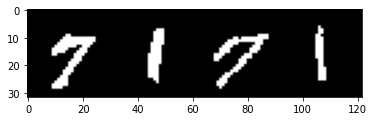

In [40]:
import matplotlib.pyplot as plt

def imshow(img):
    with torch.no_grad():
        img = torchvision.utils.make_grid(img)     
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray', vmin=0, vmax=1)
        plt.show()

imshow(images)

Network definition

In [41]:
import torch.nn as nn
import torch.nn.functional as F


class MNISTNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        #self.pool = nn.MaxPool2d(2, 2)
        self.pool1 = nn.Conv2d(6,6,2, stride=2)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.pool2 = nn.Conv2d(12,12,2, stride=2)
        self.fc1 = nn.Linear(192, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = MNISTNet()

Training

*Note*: Run training again if loss is not decreasing.

In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [43]:
from matplotlib.cbook import report_memory


def mnist_classical_training():
    for epoch in range(2):  # loop over the dataset multiple times
        running_loss = 0.
        running_grad_conv1 = 0.
        for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

        # zero the parameter gradients
            optimizer.zero_grad()

        # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                inspect_grad = torch.abs(net.conv1.weight.grad).sum().numpy()

        # print statistics
            running_loss += loss.item()
            running_grad_conv1 += inspect_grad
            report_period = 200
            if i % report_period == report_period-1:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / report_period :.3f}')
                print(f'[{epoch + 1}, {i + 1:5d}] grad_conv1_changes: {running_grad_conv1 / report_period:.3f}')
                running_loss = 0.0
                running_grad_conv1 = 0.
            

    print('Finished Training')

#mnist_classical_training()

In [44]:
def predict(images):
    with torch.no_grad():
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        print('Predicted: ', ' '.join(f'{trainset.classes[predicted[j]]:5s}||'
                                        for j in range(4)))
        imshow(images)

Predicted:  4 - four|| 4 - four|| 4 - four|| 4 - four||


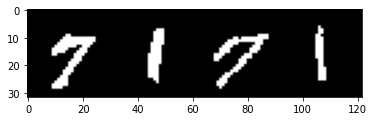

In [45]:
predict(images)

Accuracy on test set

In [46]:
testset = torchvision.datasets.MNIST(root='/home/andre/data', train=False,
                                       download=True, transform=binarize_images)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [47]:
def mnist_classical_accuracy():
    with torch.no_grad():
        correct = 0
        total = 0
        for data in testloader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the test images: {100 * correct // total} %')

# mnist_classical_accuracy()

##### Binary approach to MNIST

Network definition

In [48]:
B_MNIST = 0.25

class MNISTNetBN(nn.Module):
    def __init__(self, Q=torch.tensor([0.001]), B=B_MNIST):
        super().__init__()
        
        qb = {"Q": Q, "B": B}
        self.conv1 = Conv2dBN(1, 24, 5, stride=2, **qb)
        self.conv2 = Conv2dBN(1, 16, 4, stride=2, **qb)
        self.fc = LinearBN(6160, 10, **qb)
        
        #self.scale3 = ScaleGradient(torch.tensor([0.75]))
        
    def forward(self, x):
        first = self.conv1(x) 
        second = self.conv2(x)
        x = torch.cat([torch.flatten(l, 1) for l in [first, second]], dim=1) 
        #x = self.scale3(x)
        x = self.fc(x)
        x = torch.reshape(x, x.shape[0:2])
        return x


net = MNISTNetBN()

Training

In [49]:
def labels_to_desired(labels):
    return torch.nn.functional.one_hot(labels, num_classes=10).float()

print(labels)
print(labels_to_desired(labels))

tensor([7, 1, 7, 1])
tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])


In [50]:
def loss_bn(grad):
    with torch.no_grad():
        d = float(grad.shape[0]) * float(grad.shape[1])
        grad_flat = torch.flatten(grad)
        s = grad_flat.sum()
        return (s/d).numpy()

In [51]:
def improve_grad(grad, outputs, penalty = 1.):
    filter_not_one = (torch.sum(outputs, -1) != 1.).float()
    penalty_tensor = (1. + penalty * filter_not_one)
    return grad * torch.reshape(penalty_tensor, penalty_tensor.shape + (1,))  

In [52]:
def mnist_BN_training(lr_MNIST = 0.001, penalty=0.):
    
    lr_running = lr_MNIST 
    optimizer = torch.optim.SGD(net.parameters(), lr=lr_MNIST)
    num_lower_lr = 10

    for epoch in range(100):  # loop over the dataset multiple times
        previous_running_loss = 0.
        running_loss = 0.
        running_grad = ["conv1", "conv2", "fc"]

        for layer in running_grad:
            getattr(net, layer).stat = GradStat(getattr(net, layer).core.weight)

        if num_lower_lr==0:
            break

        for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

        # zero the parameter gradients
            optimizer.zero_grad()

        # forward + backward + optimize
            outputs = net(inputs)
            one_hot_labels = labels_to_desired(labels)

            with torch.no_grad():
                grad = neq(outputs, one_hot_labels)
                grad_loss = improve_grad(grad, outputs, penalty=penalty)
            
            outputs.backward(grad_loss)
            optimizer.step()

            # Debug
            with torch.no_grad():
                for layer in running_grad:
                    getattr(net, layer).stat.update()


        # print statistics
            running_loss += loss_bn(grad_loss)     
            report_period = 4000
            if i % report_period == report_period-1:    
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / report_period :.3f}')
                for layer in running_grad:
                    print(f'[{epoch + 1}, {i + 1:5d}] stats_{layer}_changes: {getattr(net, layer).stat.mean(2000) :.4f}')
                
                #reset
                if running_loss>previous_running_loss + 0.001 and previous_running_loss!=0.:
                    lr_running = 0.5 * lr_running
                    optimizer = torch.optim.SGD(net.parameters(), lr=lr_running)
                    num_lower_lr -= 1
                    if num_lower_lr == 0:
                        break
                    print("Lowered learning rate")
                    
                previous_running_loss = running_loss
                running_loss = 0.
                for layer in running_grad:
                    getattr(net, layer).stat.clear()

    print('Finished Training')

#mnist_BN_training()

Accuracy on the test set

In [53]:
def num_correct(t, labels):
    filter_only_one = torch.sum(t, -1)==1
    filter_one_and_correct = torch.argmax(t[filter_only_one], -1) == torch.argmax(labels_to_desired(labels)[filter_only_one], -1)
    correct = filter_one_and_correct.sum().item()
    false = filter_only_one.sum().item() - correct
    return correct, false

In [54]:
def mnist_bn_statistics():
    total_stats = {k: 0 for k in range(10)}
    stat = {k: 0 for k in range(11)}
    one_and_correct = {"correct": 0, "false": 0}
    missed_by_no_prediction  = {k: 0 for k in range(10)}
    one_detailed = {k: {"correct": 0, "false": 0} for k in range(10)}
    confusion_matrix = np.zeros((10, 10), dtype=np.int16)
    
    with torch.no_grad():
        correct = 0
        total = 0
        for data in testloader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images)
            for k in stat:
                filter_k = torch.sum(outputs, -1)==k
                stat[k] += (filter_k).sum().item()
                
                if k==0:
                    for label in missed_by_no_prediction:
                        missed_by_no_prediction[label] += (labels[filter_k]==label).sum().item()

                if k==1:
                    for prediction in one_detailed:
                        outputs_one = outputs[filter_k]
                        labels_one = labels[filter_k]
                        filter_prediction = torch.argmax(outputs_one, -1) == prediction
                        labels_prediction = labels_one[filter_prediction]

                        num_results_label = num_correct(outputs_one[filter_prediction], labels_prediction)
                        one_detailed[prediction]["correct"] += num_results_label[0]
                        one_detailed[prediction]["false"] += num_results_label[1]
                        
                        for label in range(10):
                            confusion_matrix[prediction, label] += (labels_prediction==label).sum().item()



            for k in total_stats:     
                total_stats[k] += (labels == k).sum().item()

            num_results = num_correct(outputs, labels)
            one_and_correct["correct"] += num_results[0]
            one_and_correct["false"] += num_results[1]

    print("Total counts for the labels 0,1,..,9: {}\n".format(total_stats))
    print("Number of predictions returned per input (1 is best, 0 means no prediction): {}\n".format(stat)) 
    print("Analysis when only one prediction is returned: {}\n".format(one_and_correct))
    print(f'Accuracy on only one prediction: {one_and_correct["correct"]/(stat[1]):.2f}')
    print("Analysis when only one prediction is returned per label: {}\n".format(one_detailed))
    print("For which labels 0,1,..,9 did the model not predict: {}\n".format(missed_by_no_prediction))
    print("Confusion matrix")
    print(confusion_matrix)

#mnist_bn_statistics()

Dominant weights

Which are the most important nodes?